In [21]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import datetime

from sklearn.metrics import mean_absolute_error

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [70]:
atl_df = pd.read_csv('../data/atl_df.csv', index_col = None)
atl_df

,zipcode,period_start,mean_rent_mf,median_rent_mf,sf_rental_index,trans_period,coef,sf_price_index,student_population_fraction,population,netflow_estimated,inflow_estimated,outflow_estimated,netflow_estimated_normalized,inflow_estimated_normalized,outflow_estimated_normalized,cumulative_netflow_estimated,median_income_inflow,median_income,median_income_difference,median_age_inflow,median_age,median_age_difference,confidence_score
0,30002,2018-12-01,864.321429,861.000000,139.455839,144.0,0.112014,112.494762,0.0672,6560,-29,45,74,-26,41,67,0,55394.9414,79091,-23696.0605,28.6220,41.2,-12.5780,1
1,30002,2019-01-01,866.969780,865.500000,140.034157,145.0,0.108432,112.353442,0.0672,6560,-26,65,91,-23,59,82,-26,49752.9492,79091,-29338.0508,31.8260,41.2,-9.3740,1
2,30002,2019-02-01,870.157967,871.500000,140.591074,146.0,0.136117,112.587389,0.0672,6560,-25,68,93,-25,68,93,-51,57344.6914,79091,-21746.3105,30.1530,41.2,-11.0470,1
3,30002,2019-03-01,878.043956,887.500000,141.285830,147.0,0.154795,113.908682,0.0672,6560,-22,69,91,-20,62,82,-73,58885.5313,79091,-20205.4707,29.9247,41.2,-11.2753,1
4,30002,2019-04-01,881.304945,890.000000,142.134718,148.0,0.146306,114.133338,0.0672,6560,-37,76,113,-35,71,105,-110,39910.2266,79091,-39180.7734,26.5080,41.2,-14.6920,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2965,30363,2023-02-01,2625.106881,2521.533981,321.929191,194.0,0.471078,159.063094,0.3436,4411,-13,25,38,-13,25,38,-864,68104.4219,81138,-13033.5781,25.6679,30.4,-4.7321,1
2966,30363,2023-03-01,2622.521827,2527.434211,323.787196,195.0,0.489442,159.665698,0.3436,4411,-12,29,41,-11,26,37,-876,45788.6563,81138,-35349.3438,23.9671,30.4,-6.4329,1
2967,30363,2023-04-01,2619.936774,2517.072368,324.655463,196.0,0.505767,160.315226,0.3436,4411,-26,27,53,-24,25,49,-902,41414.6289,81138,-39723.3711,27.6750,30.4,-2.7250,1
2968,30363,2023-05-01,2617.351720,2506.710526,326.057108,197.0,0.509293,162.074694,0.3436,4411,-24,37,61,-22,33,55,-926,50810.3945,81138,-30327.6055,24.8873,30.4,-5.5127,1


In [83]:
# rename columns to Prophet's expected names
atl_df.rename({'period_start': 'ds', 'sf_rental_index': 'y'}, axis = 1, inplace = True) 
atl_df.index = pd.DatetimeIndex(atl_df['ds'])

### Univariate

In [72]:
# initiate Prophet object
model = Prophet()

# fit model
model.fit(atl_df)

08:46:52 - cmdstanpy - INFO - Chain [1] start processing
08:46:52 - cmdstanpy - INFO - Chain [1] done processing


In [73]:
# create future dates for prediction
future = model.make_future_dataframe(periods=12, freq='MS') # set frequency to monthly
future.tail()

,ds
62,2024-02-01
63,2024-03-01
64,2024-04-01
65,2024-05-01
66,2024-06-01


In [74]:
# forecast object contains yhat
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
62,2024-02-01,207.349079,184.077078,231.685854
63,2024-03-01,207.774081,185.841842,229.536517
64,2024-04-01,208.644655,185.305760,230.955900
65,2024-05-01,209.338099,186.995419,230.633785
66,2024-06-01,210.063636,189.042478,231.556175


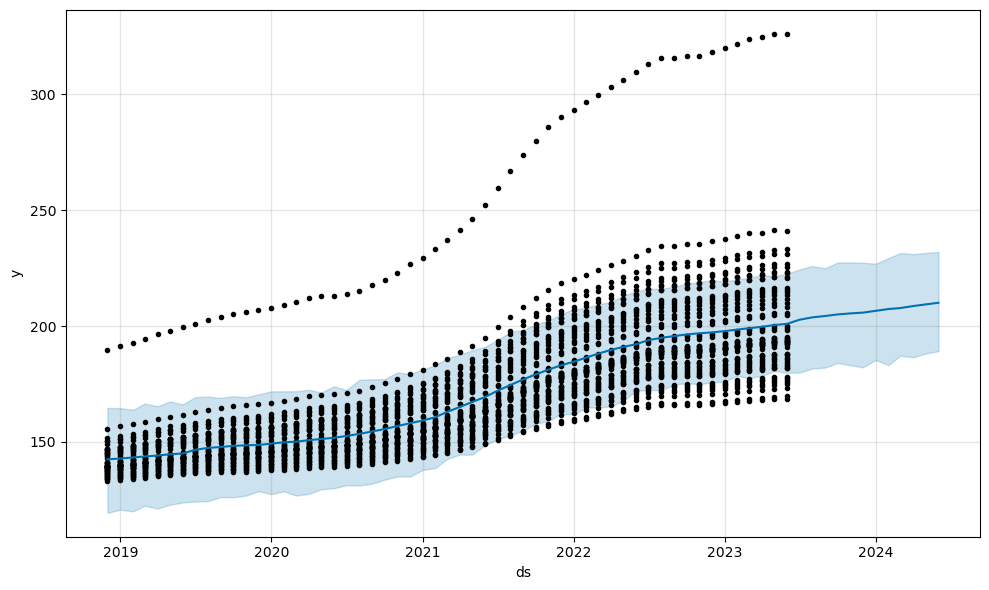

In [62]:
# plot prediction
fig1 = model.plot(forecast) 

# note this is aggregate prediction for ALL zipcodes

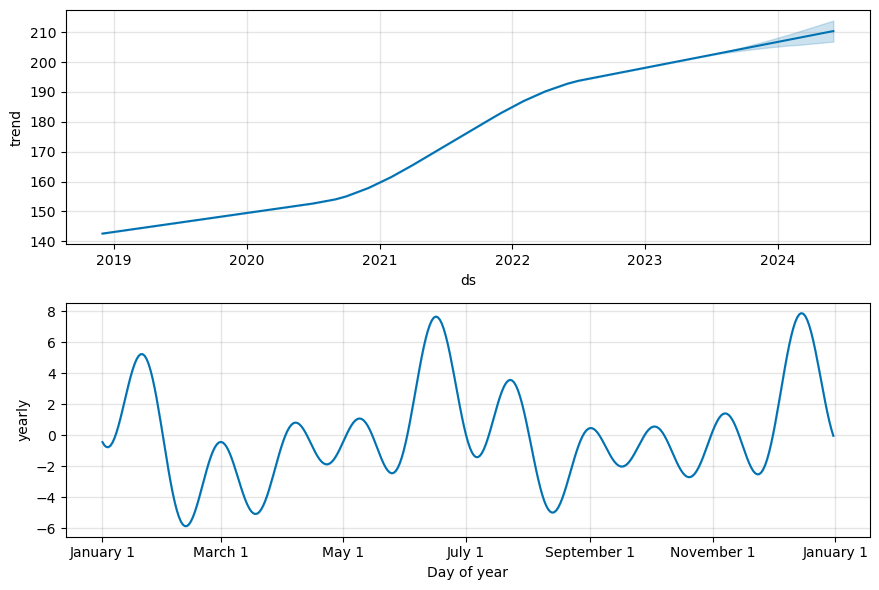

In [63]:
# plot decomposition results
fig2 = model.plot_components(forecast)

In [64]:
# interactive version of prediction
plot_plotly(model, forecast)

In [65]:
# interactive version of decomposition components
plot_components_plotly(model, forecast)

### Multivariate

In [ ]:
# group by zipcode?
# https://www.kaggle.com/code/bagavathypriya/multivariate-time-series-using-fb-prophet

In [101]:
# create train test split

from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits = 2, test_size = 300)

atl_df.sort_index(inplace=True)
#X = atl_df.drop(labels=['y'], axis=1)
#y = atl_df['y']

In [118]:
for train_index, test_index in tss.split(atl_df):
    df_train, df_test = atl_df.iloc[train_index, :], atl_df.iloc[test_index,:]

In [103]:
df_train.index

DatetimeIndex(['2018-12-01', '2018-12-01', '2018-12-01', '2018-12-01',
               '2018-12-01', '2018-12-01', '2018-12-01', '2018-12-01',
               '2018-12-01', '2018-12-01',
               ...
               '2023-01-01', '2023-01-01', '2023-01-01', '2023-01-01',
               '2023-01-01', '2023-01-01', '2023-01-01', '2023-01-01',
               '2023-01-01', '2023-01-01'],
              dtype='datetime64[ns]', name='ds', length=2670, freq=None)

In [104]:
df_test.index

DatetimeIndex(['2023-01-01', '2023-01-01', '2023-01-01', '2023-01-01',
               '2023-01-01', '2023-01-01', '2023-01-01', '2023-01-01',
               '2023-01-01', '2023-01-01',
               ...
               '2023-06-01', '2023-06-01', '2023-06-01', '2023-06-01',
               '2023-06-01', '2023-06-01', '2023-06-01', '2023-06-01',
               '2023-06-01', '2023-06-01'],
              dtype='datetime64[ns]', name='ds', length=300, freq=None)

In [106]:
df_train

,zipcode,ds,mean_rent_mf,median_rent_mf,y,trans_period,coef,sf_price_index,student_population_fraction,population,netflow_estimated,inflow_estimated,outflow_estimated,netflow_estimated_normalized,inflow_estimated_normalized,outflow_estimated_normalized,cumulative_netflow_estimated,median_income_inflow,median_income,median_income_difference,median_age_inflow,median_age,median_age_difference,confidence_score
ds,,,,,,,,,,,,,,,,,,,,,,,,
2018-12-01,30002,2018-12-01,864.321429,861.000000,139.455839,144.0,0.112014,112.494762,0.0672,6560,-29,45,74,-26,41,67,0,55394.9414,79091,-23696.0605,28.6220,41.2,-12.5780,1
2018-12-01,30311,2018-12-01,793.167398,791.000000,144.461364,144.0,0.070399,105.994349,0.0148,32214,-25,301,326,-23,272,294,0,52510.5547,40742,11768.5537,31.1929,38.9,-7.7071,1
2018-12-01,30310,2018-12-01,908.210796,789.500000,150.428310,144.0,0.089997,108.463422,0.0722,26956,-37,282,319,-33,255,288,0,53683.8516,39719,13964.8516,32.3117,36.4,-4.0883,1
2018-12-01,30309,2018-12-01,2172.704177,1850.611111,133.278411,144.0,0.150761,116.006025,0.1009,27834,-41,457,498,-37,413,450,0,70909.2813,95296,-24386.7207,32.1368,33.1,-0.9632,1
2018-12-01,30308,2018-12-01,2076.567427,1788.861111,135.011996,144.0,0.134248,114.337713,0.1338,20622,-39,314,353,-35,284,319,0,66583.5469,69724,-3140.4497,30.0086,30.8,-0.7914,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-01,30363,2023-01-01,2657.967916,2557.993421,319.929391,193.0,0.465268,159.552000,0.3436,4411,-35,32,67,-32,29,61,-851,56817.5195,81138,-24320.4805,24.4583,30.4,-5.9417,1
2023-01-01,30329,2023-01-01,1740.268390,1702.142857,185.074089,193.0,0.482480,162.095743,0.0946,26757,-33,292,325,-30,264,294,-3550,74937.0469,61620,13317.0439,32.2424,30.3,1.9424,1
2023-01-01,30337,2023-01-01,1332.517016,1378.000000,218.098634,193.0,0.430915,155.219093,0.0324,12498,-31,90,121,-28,81,109,-355,45958.8711,44882,1076.8712,28.2712,33.0,-4.7288,1


In [107]:
# initiate Prophet object
model = Prophet()

# add multivariate predictors
model.add_regressor('zipcode', standardize = False)
model.add_regressor('mean_rent_mf', standardize = False)
model.add_regressor('sf_price_index', standardize = False)
model.add_regressor('netflow_estimated', standardize = False)
model.add_regressor('median_income_inflow', standardize = False)

# fit model
model.fit(df_train)

09:16:30 - cmdstanpy - INFO - Chain [1] start processing
09:16:30 - cmdstanpy - INFO - Chain [1] done processing
09:16:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
09:16:30 - cmdstanpy - INFO - Chain [1] start processing
09:16:50 - cmdstanpy - INFO - Chain [1] done processing


In [77]:
model.params

OrderedDict([('lp__', array([[7656.2]])),
             ('k', array([[0.0940988]])),
             ('m', array([[0.379169]])),
             ('delta',
              array([[-6.87145e-11, -1.42274e-10,  1.09527e-10, -4.89645e-10,
                      -5.23291e-11,  1.77946e-10,  1.25255e-10,  4.69843e-10,
                       1.28084e-09,  9.92071e-05,  6.60678e-05,  1.30314e-01,
                       4.28509e-04,  9.27058e-04,  1.27231e-01,  4.24901e-04,
                       5.43432e-04, -8.32674e-11, -1.81899e-10, -1.57496e-04,
                      -9.24989e-02, -8.92225e-04, -8.22313e-04, -7.32148e-04,
                      -1.73310e-01]])),
             ('sigma_obs', array([[0.0458945]])),
             ('beta',
              array([[-1.38759e-03, -8.48882e-04, -2.55337e-03,  1.79729e-03,
                      -2.65398e-03, -9.11089e-04, -6.96266e-04,  9.61511e-03,
                       8.33599e-04, -1.04265e-03, -5.55621e-03, -1.56337e-03,
                      -4.80487e-04,  2

In [ ]:
# code for generating future values of each regressor for the future dataset
# using simple prophet prediction

# https://stackoverflow.com/questions/64822488/how-to-use-prophets-make-future-dataframe-with-multiple-regressors

In [ ]:
# for now, make yhat predictions just on test set, where we have existing regressor data

In [151]:
test = df_test.copy()
test = test.reset_index(drop=True)
test = test[['ds', 'zipcode', 'mean_rent_mf', 'sf_price_index', 'netflow_estimated', 'median_income_inflow']]
test.tail()

,ds,zipcode,mean_rent_mf,sf_price_index,netflow_estimated,median_income_inflow
295,2023-06-01,30316,1883.175173,163.026577,-28,62779.6719
296,2023-06-01,30315,1368.553648,162.117974,6,49112.0977
297,2023-06-01,30314,1207.880768,162.012304,-9,39014.4922
298,2023-06-01,30311,1189.942096,160.408040,-7,45465.1797
299,2023-06-01,30363,2615.314966,163.756843,-19,50662.0195


In [188]:
# use model to make a forecast on test set
forecast = model.predict(test)
forecast.tail()

# need to look into what each of these predicted values represent (upper/lower bounds)
# this has multiple data points (zipcodes) for each time value

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,extra_regressors_additive_lower,extra_regressors_additive_upper,mean_rent_mf,mean_rent_mf_lower,mean_rent_mf_upper,median_income_inflow,median_income_inflow_lower,median_income_inflow_upper,netflow_estimated,netflow_estimated_lower,netflow_estimated_upper,sf_price_index,sf_price_index_lower,sf_price_index_upper,yearly,yearly_lower,yearly_upper,zipcode,zipcode_lower,zipcode_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
295,2023-06-01,178.241985,189.426212,225.308596,177.703585,178.697470,29.570035,29.570035,29.570035,29.021317,29.021317,29.021317,4.284449,4.284449,4.284449,-48.122928,-48.122928,-48.122928,-0.483126,-0.483126,-0.483126,-5.731709,-5.731709,-5.731709,0.548718,0.548718,0.548718,79.074631,79.074631,79.074631,0.0,0.0,0.0,207.812020
296,2023-06-01,178.241985,176.566719,210.517046,177.697873,178.698130,16.024418,16.024418,16.024418,15.475700,15.475700,15.475700,6.018124,6.018124,6.018124,-63.965469,-63.965469,-63.965469,0.187882,0.187882,0.187882,-5.834202,-5.834202,-5.834202,0.548718,0.548718,0.548718,79.069365,79.069365,79.069365,0.0,0.0,0.0,194.266403
297,2023-06-01,178.241985,194.065965,229.356741,177.692737,178.698789,32.677085,32.677085,32.677085,32.128367,32.128367,32.128367,4.275232,4.275232,4.275232,-43.882163,-43.882163,-43.882163,-1.556740,-1.556740,-1.556740,-5.753629,-5.753629,-5.753629,0.548718,0.548718,0.548718,79.045668,79.045668,79.045668,0.0,0.0,0.0,210.919071
298,2023-06-01,178.241985,193.499870,227.309653,177.688734,178.701471,32.150274,32.150274,32.150274,31.601556,31.601556,31.601556,5.885554,5.885554,5.885554,-48.274036,-48.274036,-48.274036,0.590488,0.590488,0.590488,-5.811998,-5.811998,-5.811998,0.548718,0.548718,0.548718,79.211548,79.211548,79.211548,0.0,0.0,0.0,210.392259
299,2023-06-01,178.241985,199.219414,234.417267,177.683164,178.704851,38.278699,38.278699,38.278699,37.729981,37.729981,37.729981,8.620352,8.620352,8.620352,-44.808570,-44.808570,-44.808570,-0.254983,-0.254983,-0.254983,-5.772976,-5.772976,-5.772976,0.548718,0.548718,0.548718,79.946158,79.946158,79.946158,0.0,0.0,0.0,216.520684


In [190]:
plot_plotly(model, forecast)

In [191]:
plot_components_plotly(model, forecast)

In [192]:
# to compare to acxtual values, need time index
forecast.set_index('ds', inplace = True)

In [193]:
# calculate MAE between expected and predicted values
y_true = df_test['y'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 18.777


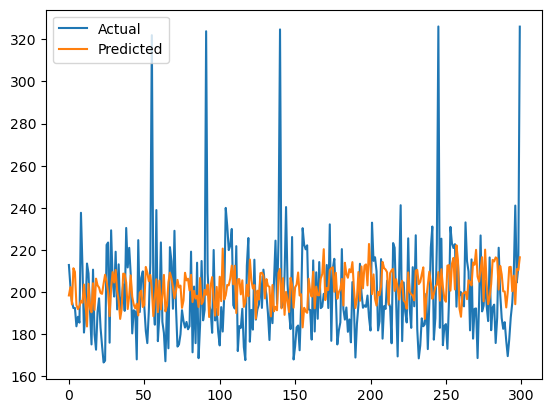

In [194]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

# these 300 indexes capture multiple zipcodes, each value in time included multiple times

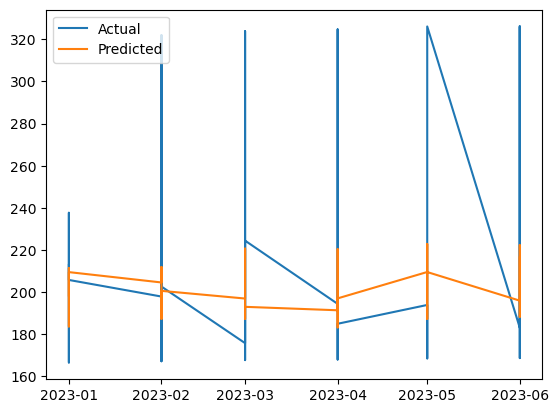

In [184]:
# plot with time series index
y_true = df_test['y']
y_pred = forecast['yhat']

plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:
# NEXT STEPS
# need to merge forecasted values with actual zipcodes to plot separate lines
# maybe create new index in original data to match up

In [171]:
# this doesn't work, not merging correctly
pred = df_test.copy()
pred['y_pred'] = forecast['yhat']
pred

,zipcode,ds,mean_rent_mf,median_rent_mf,y,trans_period,coef,sf_price_index,student_population_fraction,population,netflow_estimated,inflow_estimated,outflow_estimated,netflow_estimated_normalized,inflow_estimated_normalized,outflow_estimated_normalized,cumulative_netflow_estimated,median_income_inflow,median_income,median_income_difference,median_age_inflow,median_age,median_age_difference,confidence_score,y_pred
ds,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-01,30032,2023-01-01,1271.891299,1247.000000,212.881426,193.0,0.463253,158.795809,0.0358,45212,-110,395,505,-99,357,456,-2486,57949.3516,45436,12513.3535,32.3754,38.0,-5.6246,1,NaN
2023-01-01,30349,2023-01-01,1307.355443,1280.500000,202.786432,193.0,0.431822,155.713836,0.0470,78801,-91,707,798,-82,639,721,-1223,50415.1328,55737,-5321.8682,30.8915,33.9,-3.0085,1,NaN
2023-01-01,30082,2023-01-01,1512.408911,1488.908730,195.677120,193.0,0.476038,161.670136,0.0468,25838,1,194,193,1,175,174,-430,54271.7461,96381,-42109.2539,30.0407,37.5,-7.4593,1,NaN
2023-01-01,30360,2023-01-01,1538.823662,1521.555276,192.428737,193.0,0.488585,163.983150,0.0296,15587,-11,83,94,-10,75,85,-567,55790.8828,81204,-25413.1191,29.4362,34.4,-4.9638,1,NaN
2023-01-01,30317,2023-01-01,1892.899781,1875.480000,192.504620,193.0,0.486290,161.500167,0.0260,13895,34,157,123,31,142,111,291,58935.0625,91733,-32797.9375,30.7277,35.9,-5.1723,1,NaN
2023-01-01,30345,2023-01-01,1657.254823,1565.139860,183.785326,193.0,0.480661,161.779589,0.0361,25064,-1,162,163,-1,146,147,-838,60532.9844,96238,-35705.0156,29.7802,37.6,-7.8198,1,NaN
2023-01-01,30313,2023-01-01,1796.940110,1694.785237,188.317178,193.0,0.461617,158.702207,0.5672,11389,-10,46,56,-9,42,51,30,61393.5078,69579,-8185.4922,26.2662,21.7,4.5662,1,NaN
2023-01-01,30318,2023-01-01,1949.189196,1795.544715,185.536362,193.0,0.454781,158.238457,0.1348,57683,51,646,595,46,583,537,-960,59525.9102,60033,-507.0893,31.4110,30.6,0.8110,1,NaN
2023-01-01,30315,2023-01-01,1337.728180,1186.000000,237.653766,193.0,0.452614,157.917560,0.0300,35613,5,314,309,5,284,279,-1057,49683.6016,30631,19052.5996,30.6045,34.5,-3.8955,1,NaN


In [169]:
plt.plot(pred['y_pred'], label='Predicted')
plt.plot(pred['y'], label='Actual')

KeyError: 'y_pred'